In [1]:
# potrzebne importy
import cv2
from matplotlib import pyplot as plt
import numpy as np
import torch

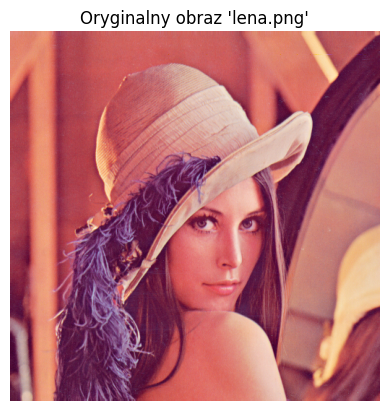

In [2]:
# wczytanie obrazu
lena = cv2.imread('lena.png', cv2.IMREAD_COLOR_RGB)

# przeskalowanie wartości pikseli
lena = lena / 255.0

# wyświetlmy wczytany obraz
plt.title("Oryginalny obraz 'lena.png'")
plt.axis('off')
plt.imshow(lena)

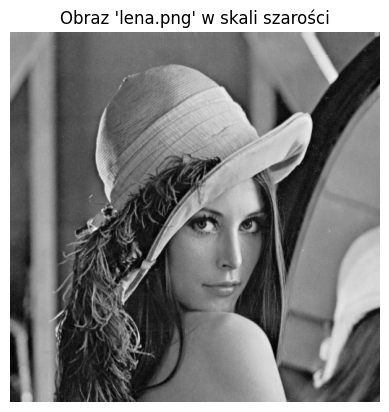

In [3]:
# konwersja do skali szarości - średnia ważona
# na podstawie: https://brandonrohrer.com/convert_rgb_to_grayscale.html
lena_gray = 0.2126 * lena[:,:,0] + 0.7152 * lena[:,:,1] + 0.0722 * lena[:,:,2]

# wyświetlmy obraz po konwersji
plt.title("Obraz 'lena.png' w skali szarości")
plt.axis('off')
plt.imshow(lena_gray, cmap='gray')

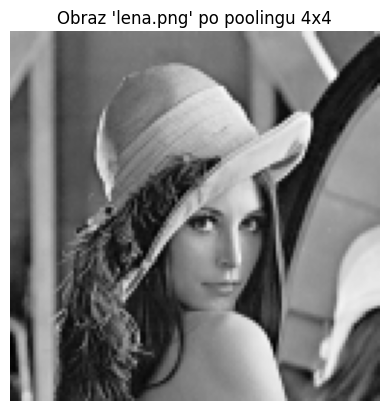

In [4]:
# pooling 4x4 w celu zmniejszenia rozmiaru obrazu
pooling = torch.nn.AvgPool2d(kernel_size=(4, 4), stride=4)
lena_pooled = pooling(torch.tensor(lena_gray).unsqueeze(0).unsqueeze(0)).squeeze().numpy()

# wyświetlmy obraz po poolingu
plt.title("Obraz 'lena.png' po poolingu 4x4")
plt.axis('off')
plt.imshow(lena_pooled, cmap='gray')

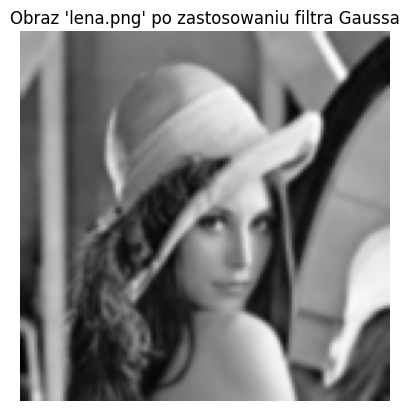

In [5]:
# funkcja do generowania filtra Gaussa zadanego rozmiaru wzięta z artykułu
def gaussian_kernel(size, sigma):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1. / (2. * np.pi * sigma**2)
    g = np.exp(-((x**2 + y**2) / (2. * sigma**2))) * normal

    return g


# zastosowanie filtra Gaussa do obrazu
gauss = gaussian_kernel(size=5, sigma=0.75)
lena_gauss = cv2.filter2D(
    lena_pooled, -1, gauss, anchor=(-1, -1), delta=0, borderType=cv2.BORDER_DEFAULT
)

# wyświetlmy obraz po filtracji Gaussa
plt.title("Obraz 'lena.png' po zastosowaniu filtra Gaussa")
plt.axis('off')
plt.imshow(lena_gauss, cmap='gray')

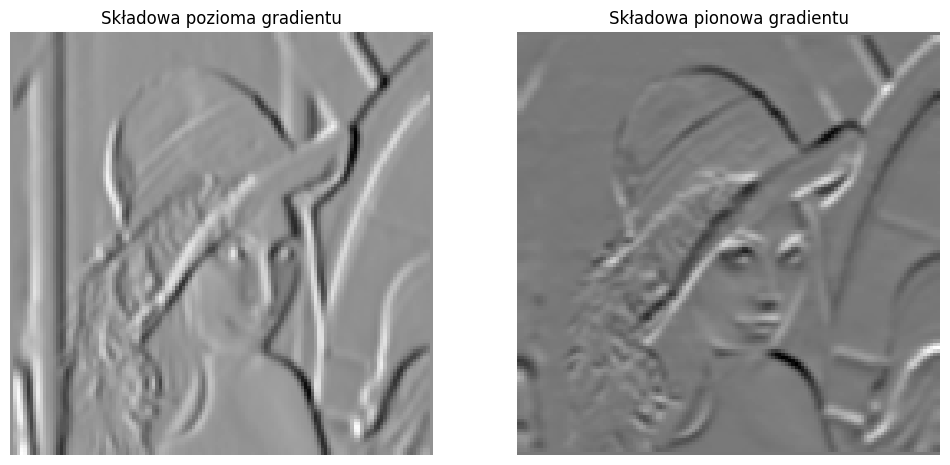

In [6]:
# zmodyfikowana funkcja do wyznaczania gradientu i kierunku krawędzi wzięta z artykułu
def sobel_filters(image):
    Kx = np.array([[-1, 0, 1], 
                   [-2, 0, 2], 
                   [-1, 0, 1]], np.float32)
    
    Ky = np.array([[1, 2, 1], 
                   [0, 0, 0], 
                   [-1, -2, -1]], np.float32)
    
    Ix = cv2.filter2D(image, -1, Kx, anchor=(-1, -1), delta=0, borderType=cv2.BORDER_DEFAULT)
    Iy = cv2.filter2D(image, -1, Ky, anchor=(-1, -1), delta=0, borderType=cv2.BORDER_DEFAULT)
    grad = np.hypot(Ix, Iy)
    grad = grad / grad.max() * 255
    theta = np.arctan2(Iy, Ix)

    return (Ix, Iy, grad, theta)


# wyznaczenie gradientów i kierunków krawędzi
grad_x, grad_y, lena_grad, theta = sobel_filters(lena_gauss)

# wyświetlmy poziomą i pionową składową gradientów
_, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].set_title("Składowa pozioma gradientu")
ax[0].axis('off')
ax[0].imshow(grad_x, cmap='gray')

ax[1].set_title("Składowa pionowa gradientu")
ax[1].axis('off')
ax[1].imshow(grad_y, cmap='gray')

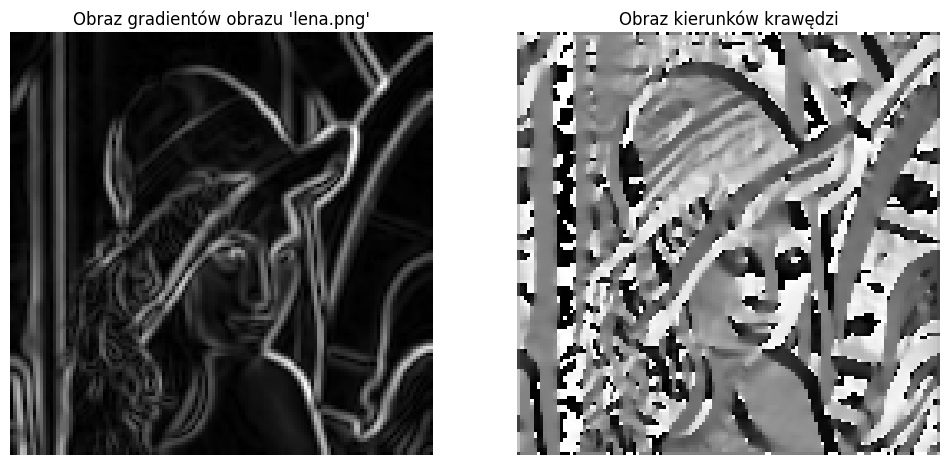

In [7]:
# wyświetlmy obraz gradientów oraz kierunków krawędzi
_, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].set_title("Obraz gradientów obrazu 'lena.png'")
ax[0].axis('off')
ax[0].imshow(lena_grad, cmap='gray')

ax[1].set_title("Obraz kierunków krawędzi")
ax[1].axis('off')
ax[1].imshow(theta, cmap='gray')

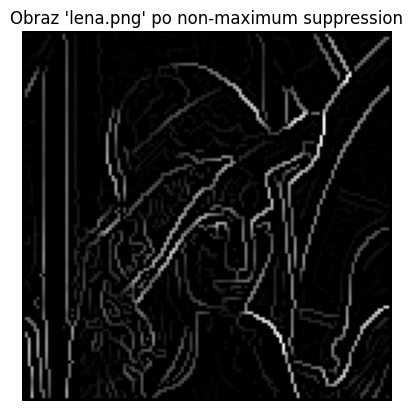

In [8]:
# funkcja do obliczenia non-maximum suppression wzięta z artykułu
def non_max_suppression(image, theta):
    H, W = image.shape
    I = np.zeros((H, W), dtype=np.int32)
    angles = theta * 180. / np.pi
    angles[angles < 0] += 180

    for i in range(1, H-1):
        for j in range(1, W-1):
            if 0 <= angles[i, j] < 22.5 or 157.5 <= angles[i, j] <= 180:
                q = image[i, j+1]
                r = image[i, j-1]
            elif 22.5 <= angles[i,j] < 67.5:
                q = image[i+1, j-1]
                r = image[i-1, j+1]
            elif 67.5 <= angles[i,j] < 112.5:
                q = image[i+1, j]
                r = image[i-1, j]
            elif 112.5 <= angles[i,j] < 157.5:
                q = image[i-1, j-1]
                r = image[i+1, j+1]
            
            if image[i, j] >= q and image[i, j] >= r:
                I[i, j] = image[i, j]

    return I


# zastosowanie non-maximum suppression
lena_nms = non_max_suppression(lena_grad, theta)

# wyświetlmy obraz po non-maximum suppression
plt.title("Obraz 'lena.png' po non-maximum suppression")
plt.axis('off')
plt.imshow(lena_nms, cmap='gray')

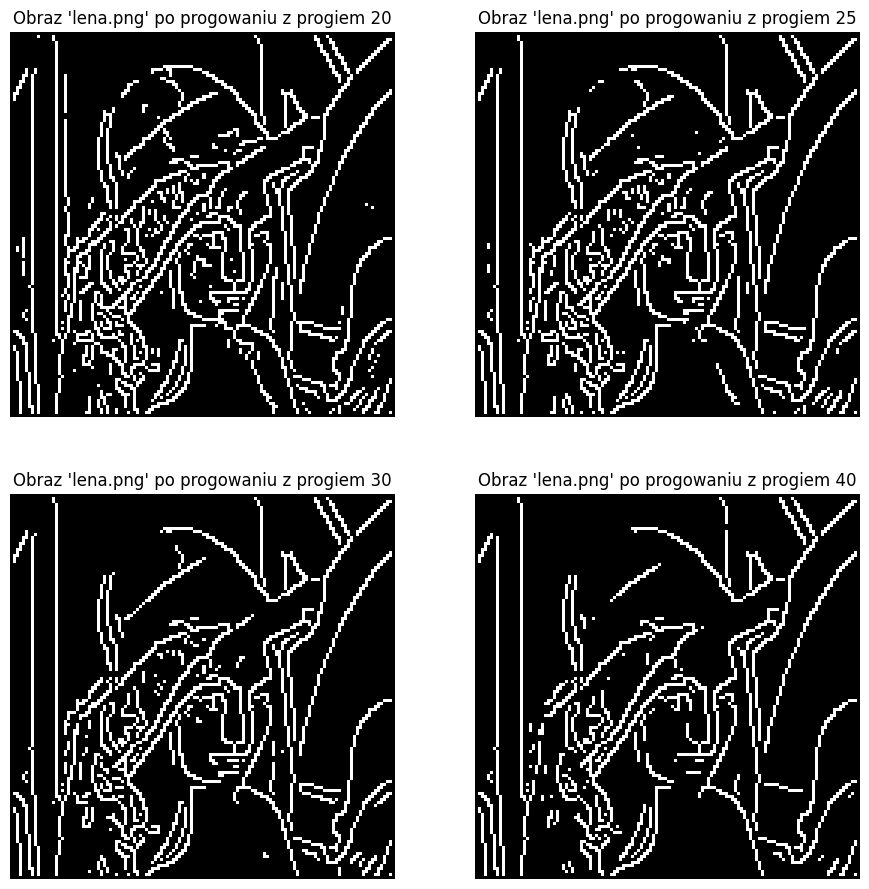

In [9]:
# funkcja wykonanująca progowanie
def thresholding(image, thresh):
    H, W = image.shape
    I = np.zeros((H, W), dtype=np.int32)
    edge_i, edge_j = np.where(image >= thresh)
    I[edge_i, edge_j] = 1

    return I


# przetestujmy różne progi i wyświetlmy wyniki
_, ax = plt.subplots(2, 2, figsize=(11, 11))
threshs = [20, 25, 30, 40]

for i, thresh in enumerate(threshs):
    ax[i//2, i%2].set_title(f"Obraz 'lena.png' po progowaniu z progiem {thresh}")
    ax[i//2, i%2].axis('off')
    ax[i//2, i%2].imshow(thresholding(lena_nms, thresh), cmap='gray')

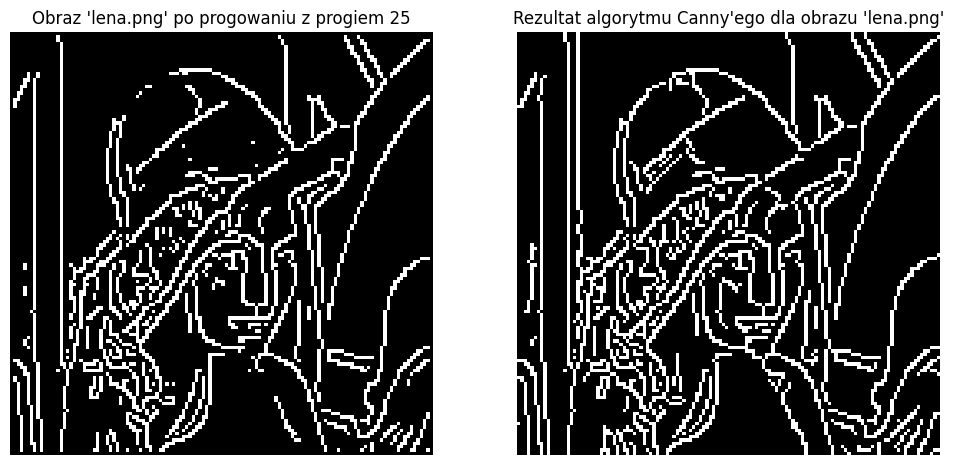

In [10]:
# wybieram najlepszy próg
lena_th = thresholding(lena_nms, thresh=25)

# użycie funkcji bibliotecznej
lena_gauss_u8 = (255 * lena_gauss).astype(np.uint8)
lena_lib = cv2.Canny(lena_gauss_u8, 25, 60, None, 3, 1)

# porównajmy rezultat algorytmu z funkcją biblioteczną
_, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].set_title("Obraz 'lena.png' po progowaniu z progiem 25")
ax[0].axis('off')
ax[0].imshow(lena_th, cmap='gray')

ax[1].set_title("Rezultat algorytmu Canny'ego dla obrazu 'lena.png'")
ax[1].axis('off')
ax[1].imshow(lena_lib, cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0058823529411764705..1.5].


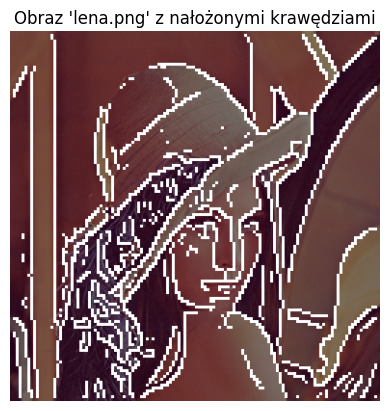

In [11]:
# przeskalowanie obrazu krawędzi do oryginalnego rozmiaru
lena_res = cv2.resize(lena_th, (lena.shape[1], lena.shape[0]), interpolation=cv2.INTER_NEAREST)
lena_res_3d = np.zeros_like(lena)
lena_res_3d[:,:,0] = lena_res_3d[:,:,1] = lena_res_3d[:,:,2] = lena_res

# nałożenie krawędzi na oryginalny obraz
comb = 0.5 * lena + 1. * lena_res_3d

# wyświetlmy oryginalny obraz z nałożonymi krawędziami
plt.title("Obraz 'lena.png' z nałożonymi krawędziami")
plt.axis('off')
plt.imshow(comb)